# **Data Science for Business - Group Project Part 2**

---
---

## 1.  **Work Environment Set Up** 
 
Thanks to the Labels.txt file we know the label of each image contained in the Character_Images folder. Thus We start by sorting all images by their label in different folders. At the same timewe create a train and validation set along the tyical 80/20 % proportion. 


In [1]:
import os
from sklearn.model_selection import train_test_split
import shutil
from collections import defaultdict

# Paths
image_folder = './Character_Images'
labels_file = './Labels.txt'
categorized_folder = './Categorized_Character_images'
train_folder = os.path.join(categorized_folder, 'train')
val_folder = os.path.join(categorized_folder, 'validation')

# Load labels and format them
labels_dict = {}
with open(labels_file, 'r') as file:
    for line in file:
        key, value = line.strip().split(',')
        formatted_filename = key.strip() + ".png"
        labels_dict[formatted_filename] = value.strip()

# Ensure folders exist for each class
label_classes = set(labels_dict.values())
for label_class in label_classes:
    os.makedirs(os.path.join(train_folder, label_class), exist_ok=True)
    os.makedirs(os.path.join(val_folder, label_class), exist_ok=True)

# Group filenames by label
files_by_label = defaultdict(list)
for filename, label in labels_dict.items():
    files_by_label[label].append(filename)

# Split files into train and validation ensuring 80/20 proportion for each label
train_files = []
val_files = []
for label, files in files_by_label.items():
    # Perform the split for each label
    train_split, val_split = train_test_split(files, test_size=0.2, random_state=42)
    # Organize train and validation files by label
    train_files.extend([(file, label) for file in train_split])
    val_files.extend([(file, label) for file in val_split])

# Function to copy files into categorized folders
def copy_files_to_categorized_folders(file_list, src_folder, dst_folder):
    for filename, label in file_list:
        src_path = os.path.join(src_folder, filename)
        dst_label_folder = os.path.join(dst_folder, label)
        dst_path = os.path.join(dst_label_folder, filename)
        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
        else:
            print(f"Warning: File not found: {src_path}")

# Organize files into train and validation folders
copy_files_to_categorized_folders(train_files, image_folder, train_folder)
copy_files_to_categorized_folders(val_files, image_folder, val_folder)

print("Files successfully organized into train and validation folders.")

# Verify the split
def count_files_by_label(folder):
    counts = {}
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            counts[label] = len(os.listdir(label_path))
    return counts

train_counts = count_files_by_label(train_folder)
val_counts = count_files_by_label(val_folder)

print("Train folder distribution:", train_counts)
print("Validation folder distribution:", val_counts)

Files successfully organized into train and validation folders.
Train folder distribution: {'9': 2605, '0': 7684, '7': 2824, '6': 6672, '1': 4522, '8': 7053, 'C': 816, '4': 3284, 'X': 888, '3': 3701, 'E': 812, '2': 4071, '5': 15018}
Validation folder distribution: {'9': 652, '0': 1921, '7': 706, '6': 1668, '1': 1131, '8': 1764, 'C': 204, '4': 822, 'X': 223, '3': 926, 'E': 203, '2': 1018, '5': 3755}


One early observation is that the digit 5 is  overrepresented in the dataset. This imbalance will be important to address during model training, as it may lead to the model favoring this class disproportionately. 

Now that we have organized all the images, we can have a look at some of them to see if and what kind of data augmentation is needed

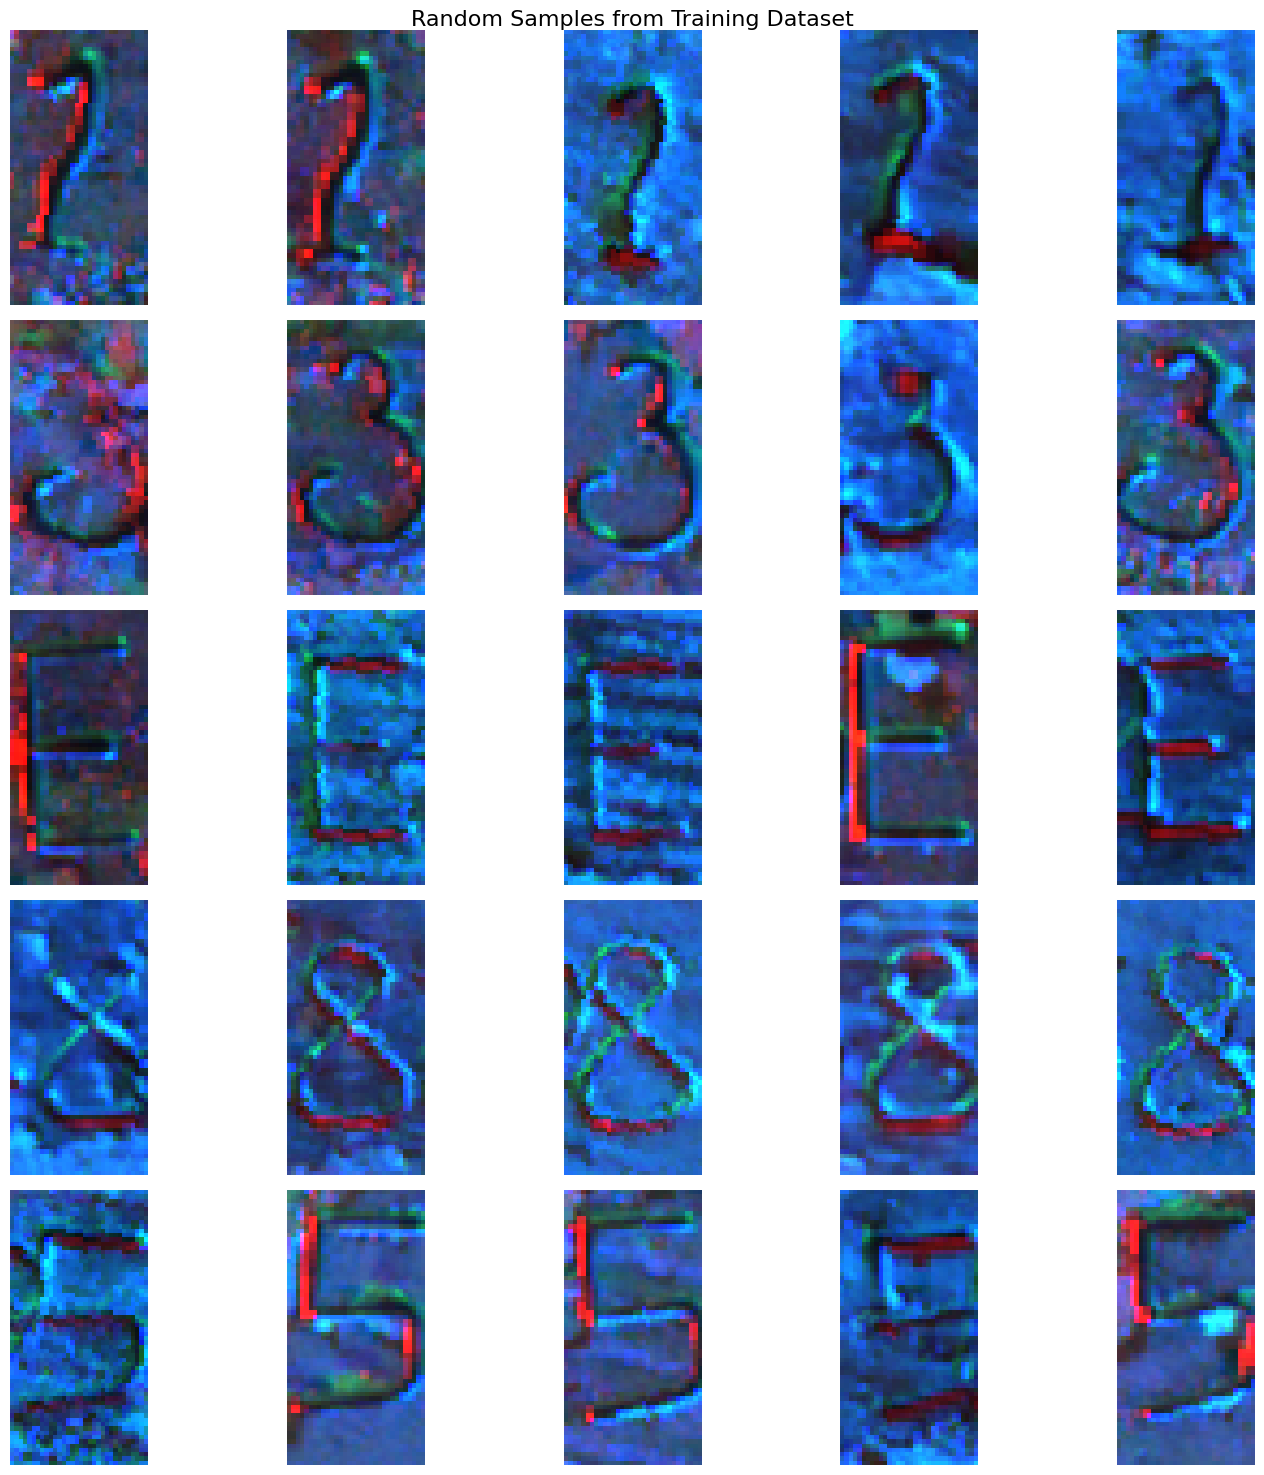

In [2]:
import matplotlib.pyplot as plt
import os
import random
from keras.preprocessing.image import load_img, img_to_array

# Paths to the train folder
train_folder = './Categorized_Character_images/train'

# Function to visualize random samples
def visualize_random_samples(folder, num_classes=5, num_images_per_class=5, img_size=(64, 32)):
    """
    Display random images from the dataset for a subset of classes.
    
    Parameters:
        folder (str): Path to the folder containing class subdirectories.
        num_classes (int): Number of classes to sample.
        num_images_per_class (int): Number of images per class to display.
        img_size (tuple): Target size for loading images.
    """
    classes = sorted(os.listdir(folder))
    sampled_classes = random.sample(classes, min(num_classes, len(classes)))

    plt.figure(figsize=(15, num_classes * 3))
    for i, class_label in enumerate(sampled_classes):
        class_folder = os.path.join(folder, class_label)
        if not os.path.isdir(class_folder):
            continue
        
        image_files = os.listdir(class_folder)
        sampled_images = random.sample(image_files, min(num_images_per_class, len(image_files)))
        
        for j, img_file in enumerate(sampled_images):
            img_path = os.path.join(class_folder, img_file)
            img = load_img(img_path, target_size=img_size)
            plt.subplot(num_classes, num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.ylabel(class_label, fontsize=14)
    
    plt.suptitle('Random Samples from Training Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_random_samples(train_folder, num_classes=5, num_images_per_class=5)

The background consistently features a mix of red and blue, while the digits are often slightly off-center, inconsistently scaled, and occasionally tilted. Based on these observations, we will apply the following data augmentations:
1.	Color Channel Variations: To introduce variability in the red and blue channels of the background.
2.  Vertical and Horizontal Shifting: To account for digits not being perfectly centered.
3.	Zooming In and Out: To address variations in digit scaling.
4.	Rotation: To simulate slight tilts in the orientation of the digits.

To improve efficiency, we will utilize Keras’s online data augmentation feature(ImageDataGenerator). This approach allows us to apply augmentations dynamically during model training, eliminating the need to store all augmented images in memory. This not only saves storage space but also ensures that the model sees a varied set of augmented data in each epoch, enhancing its generalization capabilities.

## 2.  **Data Augmentation** 



In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

def color_shift(image):
    """Applies a random shift to the red and blue channels."""
    red_shift = np.random.uniform(-40, 40)  
    blue_shift = np.random.uniform(-40, 40)  
    image[..., 0] = np.clip(image[..., 0] + red_shift, 0, 255)  
    image[..., 2] = np.clip(image[..., 2] + blue_shift, 0, 255)  
    return image

datagen = ImageDataGenerator(
    rotation_range=15,         # Random rotation (degrees)
    width_shift_range=0.005,    # Horizontal translation (fraction of total width)
    height_shift_range=0.005,   # Vertical translation (fraction of total height)
    shear_range=0.2,           # Shear intensity (shear angle in counter-clockwise direction in degrees)
    zoom_range=0.05,           # Random zoom
    horizontal_flip=False,     
    fill_mode='nearest',        # Fill pixels after transformation
    preprocessing_function = color_shift  
)

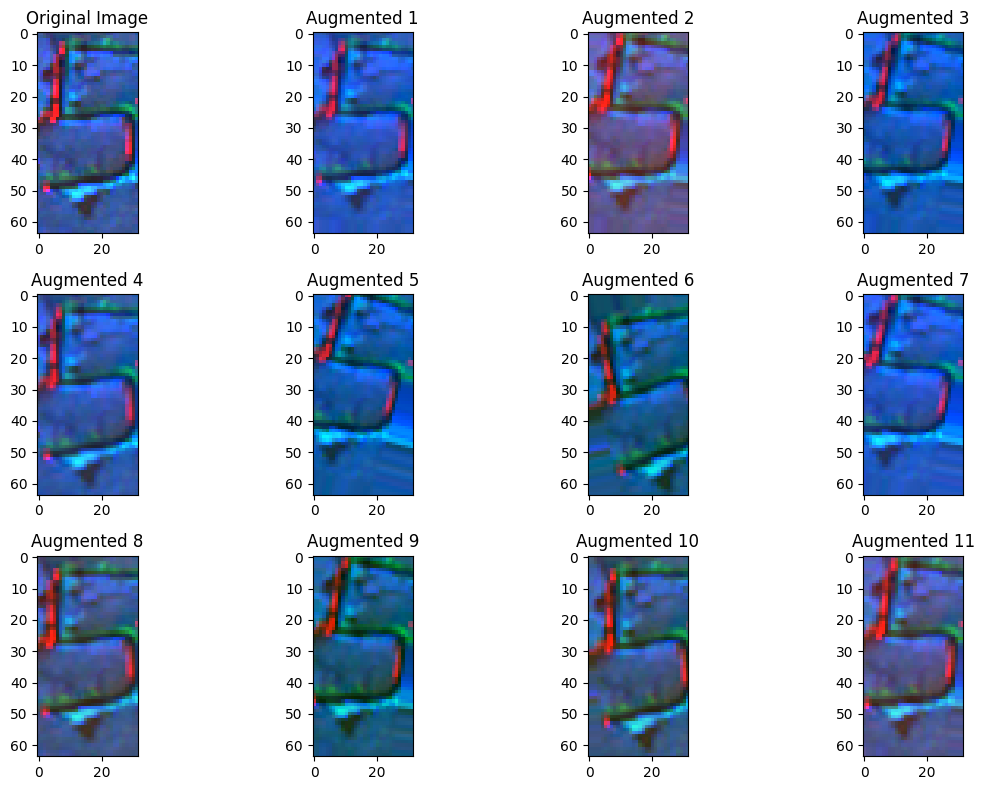

In [4]:
image_path = './Character_Images/sample_00000.png'

# Load the sample image
img = load_img(image_path, target_size=(64, 32)) 
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  

plt.figure(figsize=(12, 8))
plt.subplot(3, 4, 1)
plt.imshow(img_array[0].astype('uint8')) 
plt.title("Original Image")

# Apply standard augmentations and custom color shift
for i, batch in enumerate(datagen.flow(img_array, batch_size=1)):
    if i >= 11:  # Generate only 11 augmented images
        break
    augmented_image = batch[0].astype('uint8') 
    plt.subplot(3, 4, i + 2)
    plt.imshow(augmented_image)
    plt.title(f"Augmented {i+1}")

plt.tight_layout()
plt.show()

## 3.  **Model Definition** 


In [11]:
import random                        

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential()

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(32, 64, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution Layer 3
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Fully Connected Layer 5
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Fully Connected Layer 6
model.add(Dropout(0.2))
model.add(Dense(13))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 62, 32)        896       
                                                                 
 batch_normalization_12 (Ba  (None, 30, 62, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_14 (Activation)  (None, 30, 62, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 60, 32)        9248      
                                                                 
 batch_normalization_13 (Ba  (None, 28, 60, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 28, 60, 32)       

## 4.  **Model Training** 


In [12]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

train_datagen = datagen
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(32, 64),
    batch_size=64,
    class_mode='categorical' 
)

val_generator = test_datagen.flow_from_directory(
    val_folder,
    target_size=(32, 64),
    batch_size=64,
    class_mode='categorical'
)

# Compute class weights for imbalanced data
train_labels = []
for _, labels in train_generator:
    train_labels.extend(np.argmax(labels, axis=1))
    if len(train_labels) >= train_generator.samples:  # Collect all labels
        break

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights)

Found 59950 images belonging to 13 classes.
Found 14993 images belonging to 13 classes.
Class weights: {0: 0.6001481600128138, 1: 1.0198006328037288, 2: 1.1327778092700715, 3: 1.2460249828528671, 4: 1.4042443549142696, 5: 0.3070674165360542, 6: 0.6911778269691938, 7: 1.6329810416212682, 8: 0.6538407006293012, 9: 1.7702642846596781, 10: 5.651395173453997, 11: 5.679234558544904, 12: 5.193173943173943}


In [13]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights,  # Apply class weights
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/10
936/936 [==============================] - 65s 69ms/step - loss: 0.1846 - accuracy: 0.9469 - val_loss: 0.0332 - val_accuracy: 0.9911
Epoch 2/10
936/936 [==============================] - 60s 64ms/step - loss: 0.0541 - accuracy: 0.9838 - val_loss: 0.0304 - val_accuracy: 0.9915
Epoch 3/10
936/936 [==============================] - 59s 63ms/step - loss: 0.0413 - accuracy: 0.9872 - val_loss: 0.0727 - val_accuracy: 0.9770
Epoch 4/10
936/936 [==============================] - 60s 64ms/step - loss: 0.0340 - accuracy: 0.9897 - val_loss: 0.0226 - val_accuracy: 0.9932
Epoch 5/10
936/936 [==============================] - 61s 65ms/step - loss: 0.0250 - accuracy: 0.9922 - val_loss: 0.0269 - val_accuracy: 0.9925
Epoch 6/10
936/936 [==============================] - 60s 64ms/step - loss: 0.0236 - accuracy: 0.9921 - val_loss: 0.0233 - val_accuracy: 0.9938
Epoch 7/10
936/936 [==============================] - 60s 65ms/step - loss: 0.0246 - accuracy: 0.9925 - val_loss: 0.0180 - val_accuracy:

## 5.  **Model Performance** 



### Training and Validation Metrics ###


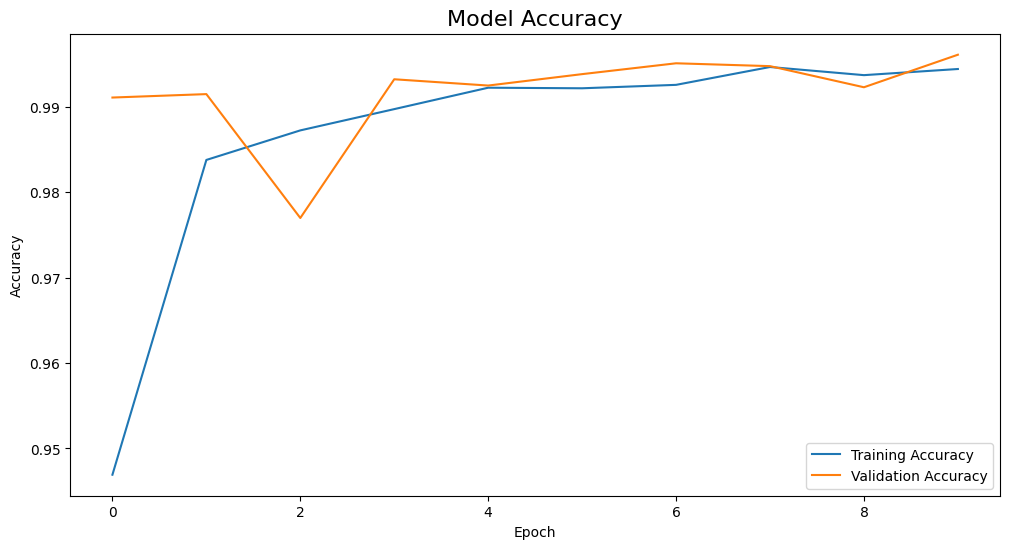

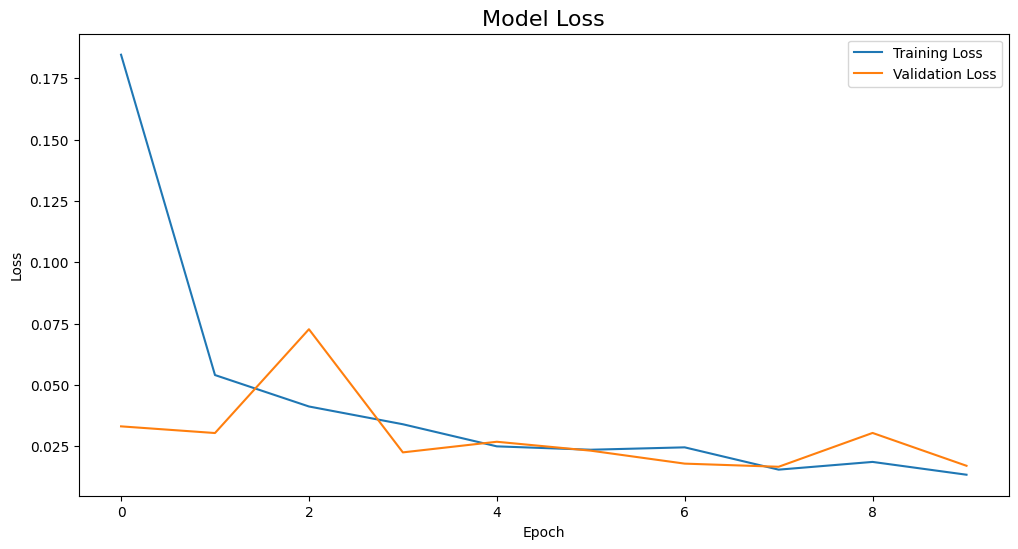


### Evaluation Metrics ###
Test Loss: 0.0171
Test Accuracy: 0.9961
Train Loss: 0.0103
Train Accuracy: 0.9968

### Classification Report and Confusion Matrix ###
235/235 [==============================] - 5s 22ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.13      0.13      1921
           1       0.08      0.08      0.08      1131
           2       0.07      0.07      0.07      1018
           3       0.06      0.06      0.06       926
           4       0.04      0.04      0.04       822
           5       0.24      0.24      0.24      3755
           6       0.11      0.11      0.11      1668
           7       0.04      0.04      0.04       706
           8       0.12      0.12      0.12      1764
           9       0.05      0.05      0.05       652
           C       0.00      0.00      0.00       204
           E       0.00      0.00      0.00       203
           X       0.03      0.03      0.03       223

 

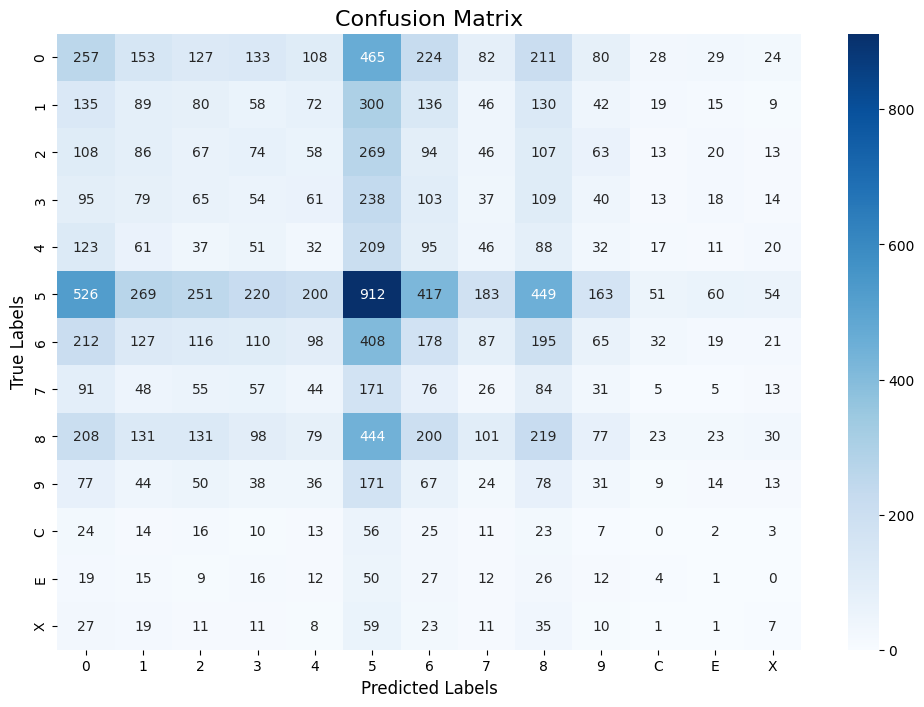


### Misclassified Images ###


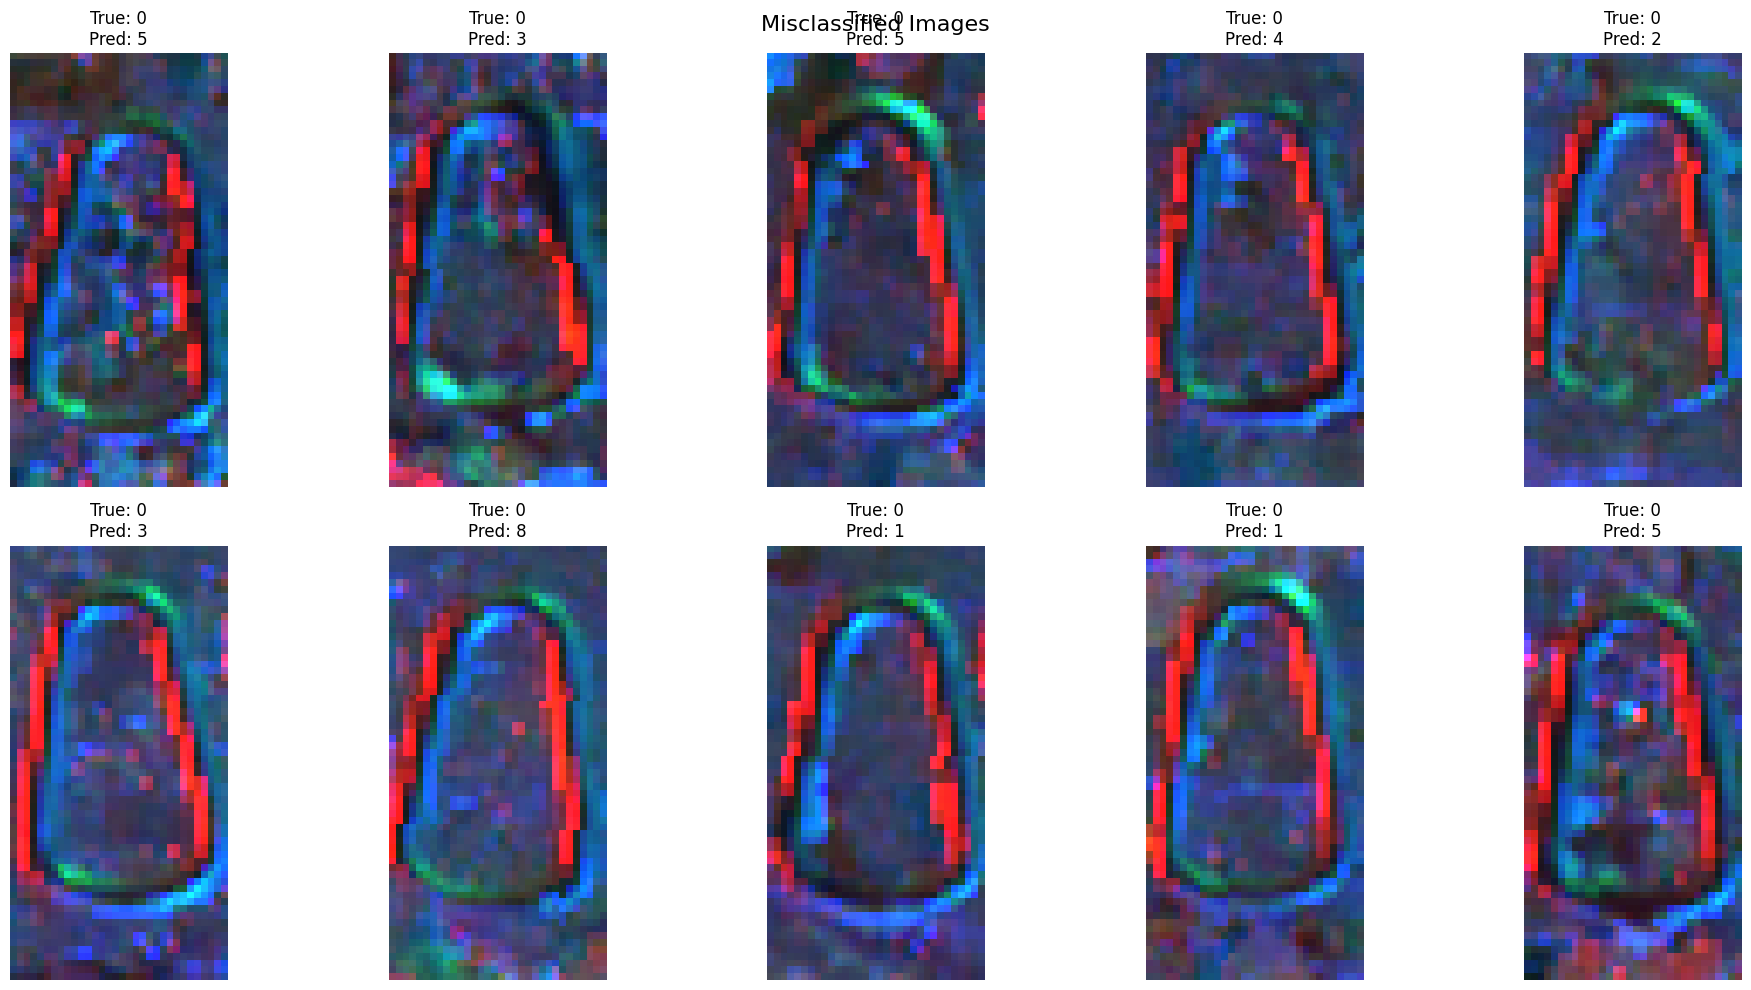

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Section 1: Plot Training and Validation Metrics
print("\n### Training and Validation Metrics ###")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Section 2: Evaluate Model on Training and Validation Data
print("\n### Evaluation Metrics ###")

test_loss, test_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# Section 3: Classification Report and Confusion Matrix
print("\n### Classification Report and Confusion Matrix ###")

# Predict all validation data
validation_steps = len(val_generator)
validation_predictions = model.predict(val_generator, steps=validation_steps, verbose=1)
validation_true_classes = np.array(val_generator.classes)  # True labels
validation_predicted_classes = np.argmax(validation_predictions, axis=1)  # Predicted labels

# Classification report
class_labels = list(val_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(validation_true_classes, validation_predicted_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(validation_true_classes, validation_predicted_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Section 4: Display Misclassified Images
print("\n### Misclassified Images ###")

# Identify misclassified indices
misclassified_indices = np.where(validation_true_classes != validation_predicted_classes)[0]

# Limit the number of images to display
num_to_display = min(len(misclassified_indices), 10)

# Display misclassified images
plt.figure(figsize=(20, 10))

for i, index in enumerate(misclassified_indices[:num_to_display]):
    # Map the index to the filename in the validation generator
    img_path = os.path.join(val_folder, val_generator.filenames[index])
    true_label = class_labels[validation_true_classes[index]]
    predicted_label = class_labels[validation_predicted_classes[index]]
    
    # Load the image
    img = load_img(img_path, target_size=(64, 32))
    img_array = img_to_array(img)
    
    # Plot the image
    plt.subplot(2, 5, i + 1)  # Adjust grid size dynamically
    plt.imshow(img_array.astype('uint8'))
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Misclassified Images", fontsize=16)
plt.show()

## 6.  **Model Saving** 


In [14]:
model.save('./6layerNN.keras')

In [17]:
test_loss, test_accuracy = model.evaluate(val_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

235/235 [==============================] - 5s 20ms/step - loss: 0.0171 - accuracy: 0.9961
Test Loss: 0.017074469476938248
Test Accuracy: 0.9960648417472839
937/937 [==============================] - 38s 40ms/step - loss: 0.0098 - accuracy: 0.9972
Train Loss: 0.009752579033374786
Train Accuracy: 0.9971643090248108
